# Reproducible Data Dependencies
## Distributing Massive, Versioned Image Datasets

24 August 2018

**Aneesh Karve**
**Jackson Brown**

## Broad Problems

Two problems at the Allen Institute for Cell Science in regards to data access:
1. We are scientists committed to **open** science.
2. We are scientists committed to **reproducible** science.

Discoverability, Schema Definition, Navigation, Packaging and Versioning, Easy of Import and Use, etc.

> "The problem is that you have scientists that want to share everything that comes to their computer. They don't know how to do that, that's your job."

## Specifying Our Problems

You cannot **automate** a system dependent on unstable access mechanisms.

You cannot determine **metadata, schema, and version** from muddy data.

You cannot **collaborate** with external groups using poor access methods.

You cannot **reproduce** experimental research from unstructured datasets.

## Building Solutions

Multiple users, varied use cases, and different preferred access mechanisms.

**A generalizable and extensible data storage and sharing mechanism.**

A core storage and sharing mechanism that can be built on top of to meet our needs.

![quilt at aics](./resources/quilt_at_aics.png)

## AICS Data Packages

All of our cell lines will have their own data package as well as other selected sets. (Random sampling, selected cells, etc)

**Enable users to get as close to the imaging and analysis pipeline as they want to.**

In [1]:
import quilt
quilt.install("aics/random_sample")

aics/random_sample already installed.
Fragments already downloaded


In [2]:
from quilt.data.aics import random_sample
random_sample

<PackageNode>
cell_segs/
fovs/
lines/
nuclei_segs/
plates/
structure_segs/
wells/
README
SCHEMA

## AICS Model Packages

We want to offer easy to use solutions for external users and collaborators to use not only our data but also our analysis and models under the same system because:

**Training Data + Trained and Packaged Model = Reproducible Machine Learning**

Would like to get to a point where we can use the `asa` functionality.
```python
from quilt.data.aics import random_sample
import fnet

random_sample.line_13(asa=label_free_predict(figsize=(20,20)))
```

In [3]:
quilt.install("aics/cell_line_samples")
quilt.install("aics/label_free")

aics/cell_line_samples already installed.
Fragments already downloaded
aics/label_free already installed.
Fragments already downloaded


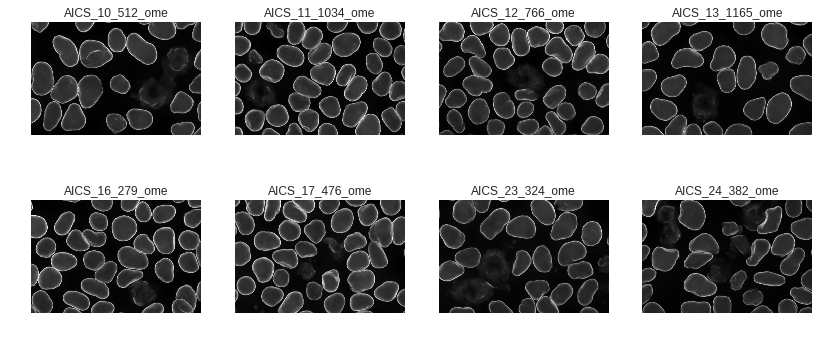

In [4]:
from quilt.data.aics import cell_line_samples
from quilt.data.aics import label_free
from matplotlib import pyplot as plt
import tifffile
import fnet

lamin_model = fnet.load_model(label_free.lamin.model())

fig, axes = plt.subplots(2, 4, figsize=(14, 6))
for img_node, ax in zip(cell_line_samples, axes.flat):
    img = tifffile.imread(img_node())
    prediction = fnet.predict(img, lamin_model, label_free.lamin.opts())
    max_proj = prediction.max(0)
    ax.imshow(max_proj)
    ax.axis("off")

## Dataset Database

It is easy to build processing pipelines for structured datasets.

It is easy to build deployment and access systems for structured datasets.

It is easy to build versioning and tracking systems for structured datasets.

In [5]:
# import and connect to a connection manager instance
import datasetdatabase as dsdb
mngr = dsdb.ConnectionManager(dsdb.LOCAL, user="jacksonb")
local = mngr.connect(dsdb.LOCAL)
local

Recent Datasets:
--------------------------------------------------------------------------------

In [6]:
# import to help us create a test dataset
import pandas as pd
import numpy as np
import pathlib
import json

# create a test dataset to upload that has various types of data
fp_ex = pathlib.Path("./example_files/")
if not fp_ex.exists():
    fp_ex.mkdir()

# creating lists of dicts to be formed into a dataframe
test = []
for i in range(4):
    fp =  fp_ex / (str(i) + ".json")
    with open(fp, "w") as write_out:
        to_write = {"hello": "world",
                    "file_num": i}
        json.dump(to_write, write_out)
    
    d = {}
    d["dicts"] = to_write
    d["bools"] = np.random.rand() < 0.5
    d["floats"] = np.random.rand() * 100
    d["ndarrays"] = np.random.rand(2, 2)
    d["files"] = str(fp)
    test.append(d)

# convert this example both to dataframe
test = pd.DataFrame(test)
test

,bools,dicts,files,floats,ndarrays
0,True,"{'hello': 'world', 'file_num': 0}",example_files/0.json,29.553868,"[[0.03961728265386866, 0.36574362518731174], [..."
1,False,"{'hello': 'world', 'file_num': 1}",example_files/1.json,72.074092,"[[0.49153408590451175, 0.6558689992950782], [0..."
2,True,"{'hello': 'world', 'file_num': 2}",example_files/2.json,38.762024,"[[0.8231308186313561, 0.1510421031706638], [0...."
3,True,"{'hello': 'world', 'file_num': 3}",example_files/3.json,93.430722,"[[0.31655354980467665, 0.616912935465658], [0...."


In [7]:
local.upload_dataset(test,
                     name="test dataset",
                     description="this is the hello world of dataset ingestion",
                     type_map={"bools": bool,
                               "dicts": dict,
                               "files": str,
                               "floats": float,
                               "ndarrays": np.ndarray},
                     filepath_columns="files")
local

Validating Dataset...
[============================================================] 100.0% (80/80) ~ 0:00:00 remaining
Creating Iota...
[============================================================] 100.0% (20/20) ~ 0:00:00 remaining
Creating Junction Items...
[============================================================] 100.0% (24/24) ~ 0:00:00 remaining
Dataset upload complete!


Recent Datasets:
--------------------------------------------------------------------------------
{'DatasetId': 1, 'Name': 'test dataset', 'Description': 'this is the hello world of dataset ingestion', 'SourceId': 1, 'FilepathColumns': "['files']", 'Created': '2018-08-06 21:49:23.006197'}

In [8]:
def add_to_col(dataset, params):
    dataset[params["col"]] += params["add"]
    return dataset

In [9]:
local.process_run(add_to_col,
                  1,
                  alg_parameters={"col": "floats", "add": 12},
                  dataset_parameters={"name": "processing test",
                                      "description": "showing how to process datasets",
                                      "filepath_columns": "files"})
local

Validating Dataset...
[============================================================] 100.0% (80/80) ~ 0:00:00 remaining
Creating Iota...
[============================================================] 100.0% (20/20) ~ 0:00:00 remaining
Creating Junction Items...
[============================================================] 100.0% (24/24) ~ 0:00:00 remaining
Dataset upload complete!


Recent Datasets:
--------------------------------------------------------------------------------
{'DatasetId': 2, 'Name': 'processing test', 'Description': 'showing how to process datasets', 'SourceId': 2, 'FilepathColumns': "['files']", 'Created': '2018-08-06 21:49:41.461041'}
{'DatasetId': 1, 'Name': 'test dataset', 'Description': 'this is the hello world of dataset ingestion', 'SourceId': 1, 'FilepathColumns': "['files']", 'Created': '2018-08-06 21:49:23.006197'}

In [10]:
local.process_run(add_to_col,
                  2,
                  alg_parameters={"col": "floats", "add": 42},
                  dataset_parameters={"name": "secondary processing",
                                      "description": "additionall processing had to be done",
                                      "filepath_columns": "files"})
local

Validating Dataset...
[============================================================] 100.0% (80/80) ~ 0:00:00 remaining
Creating Iota...
[============================================================] 100.0% (20/20) ~ 0:00:00 remaining
Creating Junction Items...
[============================================================] 100.0% (24/24) ~ 0:00:00 remaining
Dataset upload complete!


Recent Datasets:
--------------------------------------------------------------------------------
{'DatasetId': 3, 'Name': 'secondary processing', 'Description': 'additionall processing had to be done', 'SourceId': 3, 'FilepathColumns': "['files']", 'Created': '2018-08-06 21:49:46.630293'}
{'DatasetId': 2, 'Name': 'processing test', 'Description': 'showing how to process datasets', 'SourceId': 2, 'FilepathColumns': "['files']", 'Created': '2018-08-06 21:49:41.461041'}
{'DatasetId': 1, 'Name': 'test dataset', 'Description': 'this is the hello world of dataset ingestion', 'SourceId': 1, 'FilepathColumns': "['files']", 'Created': '2018-08-06 21:49:23.006197'}

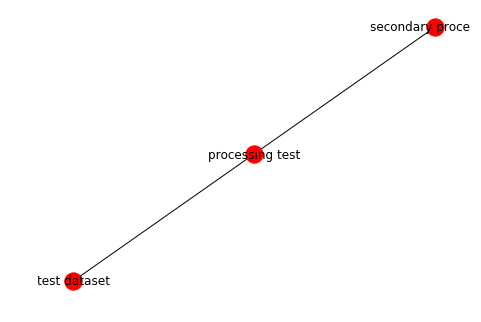

In [12]:
local.display_dataset_graph(1)

In [13]:
local.get_dataset(3)

,bools,dicts,files,floats,ndarrays
0,True,"{'hello': 'world', 'file_num': 0}",/home/jovyan/.local/share/QuiltCli/quilt_packa...,83.553868,"[[0.03961728265386866, 0.36574362518731174], [..."
1,False,"{'hello': 'world', 'file_num': 1}",/home/jovyan/.local/share/QuiltCli/quilt_packa...,126.074092,"[[0.49153408590451175, 0.6558689992950782], [0..."
2,True,"{'hello': 'world', 'file_num': 2}",/home/jovyan/.local/share/QuiltCli/quilt_packa...,92.762024,"[[0.8231308186313561, 0.1510421031706638], [0...."
3,True,"{'hello': 'world', 'file_num': 3}",/home/jovyan/.local/share/QuiltCli/quilt_packa...,147.430722,"[[0.31655354980467665, 0.616912935465658], [0...."


In [14]:
local.export_to_quilt(3)

'dsdb/secondary_processing'

In [15]:
from quilt.data.dsdb import secondary_processing
secondary_processing

<PackageNode>
files/
README
data

In [16]:
secondary_processing.files

<GroupNode>
json_2/
json_3/
json_4/
json_5/